In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

In [3]:
# Проверим данные
print(train_df.info(), '\n=========================================')
print(test_df.info(), '\n=========================================')
print(sample_submission_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63438 entries, 0 to 63437
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             63438 non-null  int64 
 1   word           63438 non-null  object
 2   stress         63438 non-null  int64 
 3   num_syllables  63438 non-null  int64 
 4   lemma          63438 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.4+ MB
None 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29960 entries, 0 to 29959
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             29960 non-null  int64 
 1   word           29960 non-null  object
 2   num_syllables  29960 non-null  int64 
 3   lemma          29960 non-null  object
dtypes: int64(2), object(2)
memory usage: 936.4+ KB
None 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29960 entries, 0 to 29959
Data columns (total 2 columns):
 # 

In [4]:
# Окей, NaN и NULL нет
print(train_df.head(), '\n=========================================')
print(test_df.head(), '\n=========================================')
print(sample_submission_df.head())

   id      word  stress  num_syllables     lemma
0   0   румяной       2              3   румяный
1   1   цифрами       1              3     цифра
2   2   слугами       1              3     слуга
3   3  выбирает       3              4  выбирать
4   4  управдом       3              3  управдом 
   id           word  num_syllables        lemma
0   0      эпилепсия              5    эпилепсия
1   1    относящейся              5   относиться
2   2  размышлениями              6  размышление
3   3         модемы              3        модем
4   4          солнц              1       солнце 
   id  stress
0   0       1
1   1       1
2   2       1
3   3       1
4   4       1


In [5]:
# Чтобы не прописывать весь алфавит и символы, которые могут встретиться, 
# сделаем функцию для создания словаря из попавшихся символов
def build_vocab(words):
    chars = set()
    for word in words:
        for ch in word:
            chars.add(ch)
    chars = sorted(list(chars))
    # Не забудем паддинг
    char2idx = {ch: idx + 1 for idx, ch in enumerate(chars)}
    char2idx['<PAD>'] = 0
    idx2char = {idx: ch for ch, idx in char2idx.items()}
    return char2idx, idx2char

# Обратный процесс
def encode_word(word, char2idx):
    return [char2idx.get(ch, 0) for ch in word]  # если символ не найден, возвращаем 0

In [6]:
# Создадим кастомный класс датасета 
class StressDataset(Dataset):
    def __init__(self, csv_file, char2idx=None, mode='train'):
        """
        mode: 'train' - есть метка stress, 'test' - её нет.
        """
        self.data = pd.read_csv(csv_file)
        self.mode = mode
        self.words = self.data['word'].astype(str).tolist()
        if mode == 'train':
            self.stresses = self.data['stress'].tolist()  # метки (1-indexed)
        else:
            self.stresses = None
        self.num_syllables = self.data['num_syllables'].tolist()
        self.ids = self.data['id'].tolist()

        # Если словарь не передан, строим его по тренировочным словам.
        if char2idx is None:
            self.char2idx, self.idx2char = build_vocab(self.words)
        else:
            self.char2idx = char2idx
        self.encoded_words = [encode_word(word, self.char2idx) for word in self.words]

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        item = {
            'id': self.ids[idx],
            'word': self.words[idx],
            'encoded': torch.tensor(self.encoded_words[idx], dtype=torch.long),
            'num_syllables': self.num_syllables[idx]
        }
        if self.mode == 'train':
            item['stress'] = self.stresses[idx]
        return item

    def get_char2idx(self):
        return self.char2idx

In [7]:
# Функция для формирования батча (нам нужно учитывать паддинг)
def collate_fn(batch):
    ids = [b['id'] for b in batch]
    encoded_seqs = [b['encoded'] for b in batch]
    lengths = [len(seq) for seq in encoded_seqs]
    padded = nn.utils.rnn.pad_sequence(encoded_seqs, batch_first=True, padding_value=0)
    num_syllables = torch.tensor([b['num_syllables'] for b in batch], dtype=torch.long)
    stresses = None
    if 'stress' in batch[0]:
        stresses = torch.tensor([b['stress'] for b in batch], dtype=torch.long)
    return {
        'id': ids,
        'encoded': padded,
        'lengths': lengths,
        'num_syllables': num_syllables,
        'stress': stresses
    }

In [8]:
import torch
import torch.nn as nn

class StressModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_size=128, num_layers=2, num_classes=6, dropout=0.3):
        super(StressModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.dp = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (h_n, c_n) = self.lstm(packed)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        attn_weights = torch.softmax(self.attention(output), dim=1)
        context = torch.sum(attn_weights * output, dim=1)
        
        context = self.dp(context)
        logits = self.fc(context)
        return logits

In [9]:
# Обрежем вероятности на количество реальных слогов и проиндексируем с нуля
def masked_cross_entropy_loss(logits, stresses, num_syllables):
    batch_loss = 0.0
    batch_size = logits.size(0)
    for i in range(batch_size):
        valid_len = num_syllables[i].item()  # число слогов в слове
        logit_i = logits[i, :valid_len]  # учитываем только допустимые позиции
        target = stresses[i].item() - 1  # перевод target'а в 0-indexed
        loss_i = nn.functional.cross_entropy(logit_i.unsqueeze(0), torch.tensor([target], device=logits.device))
        batch_loss += loss_i
    return batch_loss / batch_size

# Функция обучения модели
def train_model(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        inputs = batch['encoded'].to(device)
        lengths = batch['lengths']
        logits = model(inputs, lengths)
        stresses = batch['stress'].to(device)
        num_syllables = batch['num_syllables'].to(device)
        loss = masked_cross_entropy_loss(logits, stresses, num_syllables)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Функция для оценки точности
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = batch['encoded'].to(device)
            lengths = batch['lengths']
            logits = model(inputs, lengths)
            stresses = batch['stress'].to(device)
            num_syllables = batch['num_syllables'].to(device)
            loss = masked_cross_entropy_loss(logits, stresses, num_syllables)
            total_loss += loss.item()
            for i in range(logits.size(0)):
                valid_len = num_syllables[i].item()
                logit_i = logits[i, :valid_len]
                pred = torch.argmax(logit_i).item()  # 0-indexed
                true = stresses[i].item() - 1
                if pred == true:
                    correct += 1
                total += 1
    epoch_loss = total_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_acc, epoch_loss

# Функция предсказания на тестовых данных 
# (именно которые без готовой расстановки ударений)
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    ids_all = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            inputs = batch['encoded'].to(device)
            lengths = batch['lengths']
            logits = model(inputs, lengths)
            num_syllables = batch['num_syllables']
            ids_batch = batch['id']
            for i in range(logits.size(0)):
                valid_len = num_syllables[i].item()
                logit_i = logits[i, :valid_len]
                # Выбираем индекс с максимальным значением и переводим в 1-indexed.
                pred = torch.argmax(logit_i).item() + 1
                predictions.append(pred)
            ids_all.extend(ids_batch)
    return ids_all, predictions

In [10]:
def main(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if args.mode == 'train':
        dataset = StressDataset('train.csv', mode='train')
        train_size = int(args.train_size * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        char2idx = dataset.char2idx
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn)

        max_num_syllables = max(dataset.num_syllables)
        model = StressModel(vocab_size=len(char2idx), embed_dim=args.embed_dim, hidden_size=args.hidden_size, num_classes=max_num_syllables)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
        num_epochs = args.epochs

        history = {'train_losses': [], 'val_losses': []}
        best_val_loss = float('inf')
        for epoch in range(num_epochs):
            train_losses = []
            val_losses = []
            train_loss = train_model(model, train_loader, optimizer, device)
            val_acc, val_loss = evaluate_model(model, val_loader, device)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({'model_state_dict': model.state_dict(), 'char2idx': char2idx}, args.model_path)
                print(f"\nНовая лучшая модель сохранена с val_loss={val_loss:.4f}\n")
            history['train_losses'].append(train_loss)
            history['val_losses'].append(val_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        print(f"Model saved to {args.model_path}")
        return history
    
    elif args.mode == 'predict':
        checkpoint = torch.load(args.model_path, map_location=device)
        char2idx = checkpoint['char2idx']
        test_dataset = StressDataset('test.csv', char2idx=char2idx, mode='test')
        test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn)
        max_num_syllables = max(test_dataset.num_syllables)
        model = StressModel(vocab_size=len(char2idx), embed_dim=args.embed_dim, hidden_size=args.hidden_size, num_classes=max_num_syllables)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        ids_all, preds = predict(model, test_loader, device)
        submission = pd.DataFrame({'id': ids_all, 'stress': preds})
        submission.to_csv(args.output, index=False)
        print(f"Submission saved to {args.output}")
        return None

In [11]:
class Args():
    def __init__(self, args):
        self.mode = args['mode']
        self.batch_size = args['batch_size']
        self.epochs = args['epochs']
        self.lr = args['lr']
        self.embed_dim = args['embed_dim']
        self.hidden_size = args['hidden_size']
        self.train_size = args['train_size']
        self.model_path = args['model_path']
        self.output = args['output']

In [12]:
if __name__ == '__main__':
    args = dict()
    args['mode'] = 'train'
    # args['mode'] = 'predict'
    args['batch_size'] = 64
    args['epochs'] = 15
    args['lr'] = 0.001
    args['embed_dim'] = 64
    args['hidden_size'] = 128
    args['train_size'] = 0.90
    args['model_path'] = 'stress_model_5.pth'
    args['output'] = 'submission.csv'
    parser = Args(args)
    # Trin
    history = main(parser)
    # Predict
    args['mode'] = 'predict'
    parser = Args(args)
    main(parser)

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.91it/s]



Новая лучшая модель сохранена с val_loss=0.6247

Epoch 1/15, Train Loss: 0.7680, Validation Loss: 0.6247, Validation Accuracy: 0.7412


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.21it/s]



Новая лучшая модель сохранена с val_loss=0.4770

Epoch 2/15, Train Loss: 0.5535, Validation Loss: 0.4770, Validation Accuracy: 0.8072


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.42it/s]



Новая лучшая модель сохранена с val_loss=0.4312

Epoch 3/15, Train Loss: 0.4615, Validation Loss: 0.4312, Validation Accuracy: 0.8258


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.58it/s]



Новая лучшая модель сохранена с val_loss=0.3808

Epoch 4/15, Train Loss: 0.3977, Validation Loss: 0.3808, Validation Accuracy: 0.8523


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.17it/s]



Новая лучшая модель сохранена с val_loss=0.3540

Epoch 5/15, Train Loss: 0.3460, Validation Loss: 0.3540, Validation Accuracy: 0.8599


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.45it/s]



Новая лучшая модель сохранена с val_loss=0.3320

Epoch 6/15, Train Loss: 0.3054, Validation Loss: 0.3320, Validation Accuracy: 0.8712


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.82it/s]



Новая лучшая модель сохранена с val_loss=0.3201

Epoch 7/15, Train Loss: 0.2691, Validation Loss: 0.3201, Validation Accuracy: 0.8783


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.02it/s]



Новая лучшая модель сохранена с val_loss=0.3083

Epoch 8/15, Train Loss: 0.2411, Validation Loss: 0.3083, Validation Accuracy: 0.8860


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.97it/s]



Новая лучшая модель сохранена с val_loss=0.2950

Epoch 9/15, Train Loss: 0.2143, Validation Loss: 0.2950, Validation Accuracy: 0.8927


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.03it/s]


Epoch 10/15, Train Loss: 0.1925, Validation Loss: 0.2981, Validation Accuracy: 0.8963


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.36it/s]



Новая лучшая модель сохранена с val_loss=0.2817

Epoch 11/15, Train Loss: 0.1777, Validation Loss: 0.2817, Validation Accuracy: 0.9040


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.51it/s]


Epoch 12/15, Train Loss: 0.1562, Validation Loss: 0.2864, Validation Accuracy: 0.9007


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.97it/s]


Epoch 13/15, Train Loss: 0.1477, Validation Loss: 0.2946, Validation Accuracy: 0.9049


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.13it/s]


Epoch 14/15, Train Loss: 0.1370, Validation Loss: 0.3153, Validation Accuracy: 0.9002


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.83it/s]


Epoch 15/15, Train Loss: 0.1265, Validation Loss: 0.3015, Validation Accuracy: 0.9054
Model saved to stress_model_5.pth


Predicting: 100%|████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 62.11it/s]

Submission saved to submission.csv


In [13]:
# График для проверки переобучения
def plot_losses(history):
    train_losses = history['train_losses']
    val_losses = history['val_losses']
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

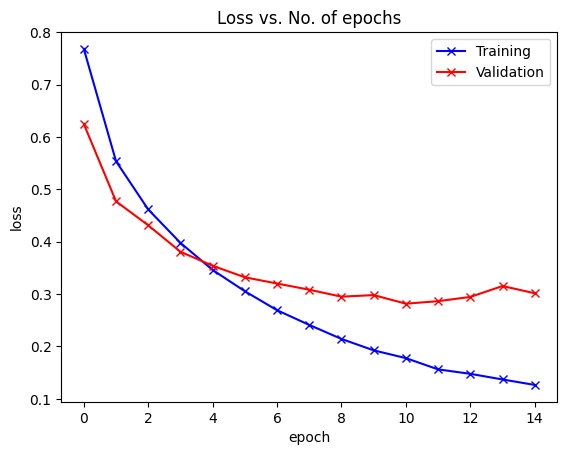

In [14]:
plot_losses(history)